In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.02

klin =0

nband = 320

ng =10

ng_refs = (/ 3 , 2 , 5 /) 

nref =3

nv = 50

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =257

vstar = 20

data w_diffuse
     &     /1.6 , 1.8 , 1.8 , 1.8,
     &     1.7 , 1.6 , 1.4 , 1.4,
     &     1.7 , 1.8/

data wgt
     &     /0.3 , 0.3 , 0.3 , 0.3,
     &     0.3 , 0.3 , 0.6 , 0.6,
     &     0.6 , 0.6/

atmosphere_profiles/saw75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

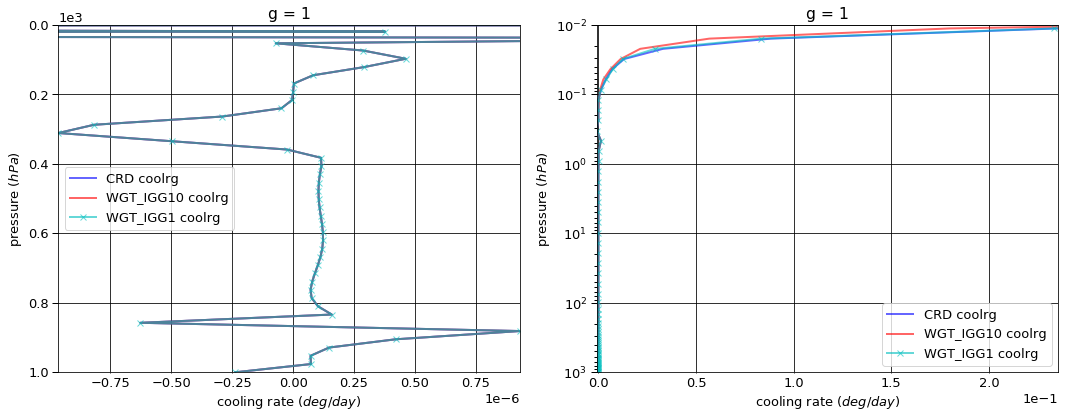

# Figure: cooling rate g-group 2

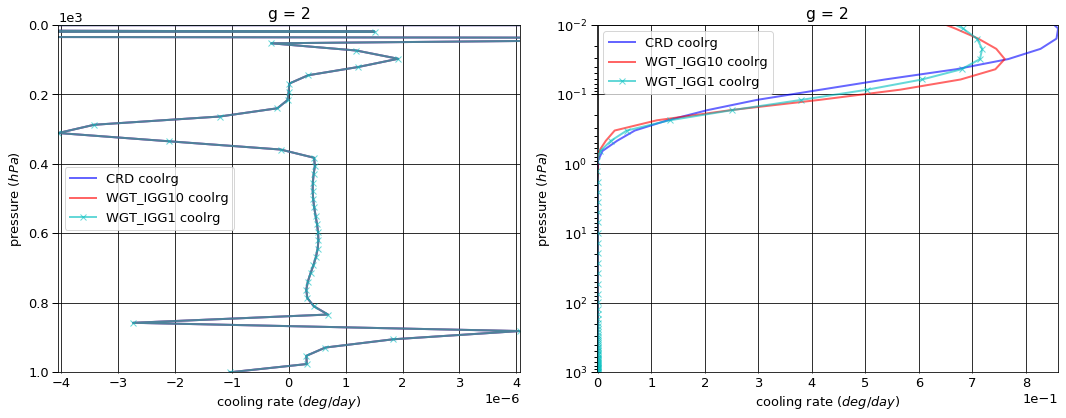

# Figure: cooling rate g-group 3

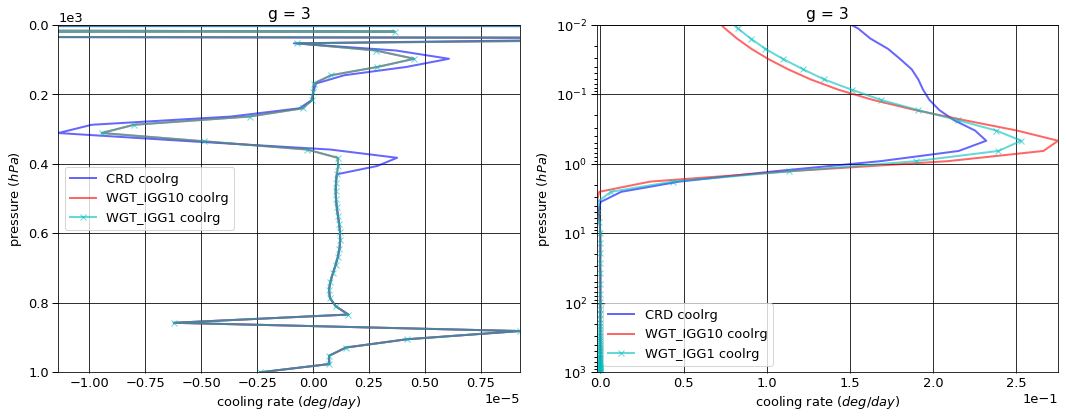

# Figure: cooling rate g-group 4

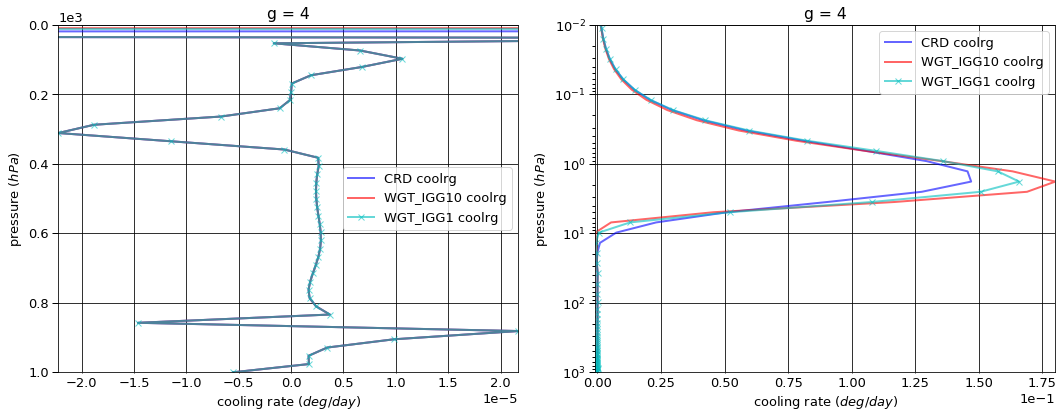

# Figure: cooling rate g-group 5

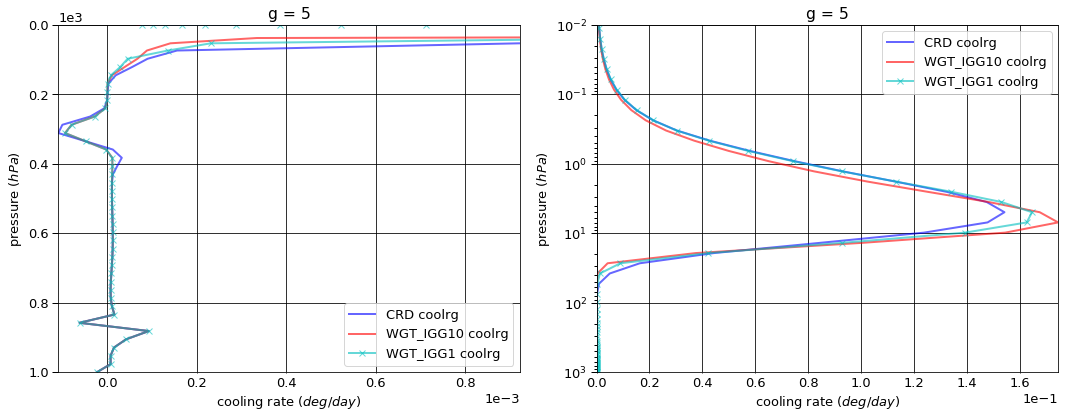

# Figure: cooling rate g-group 6

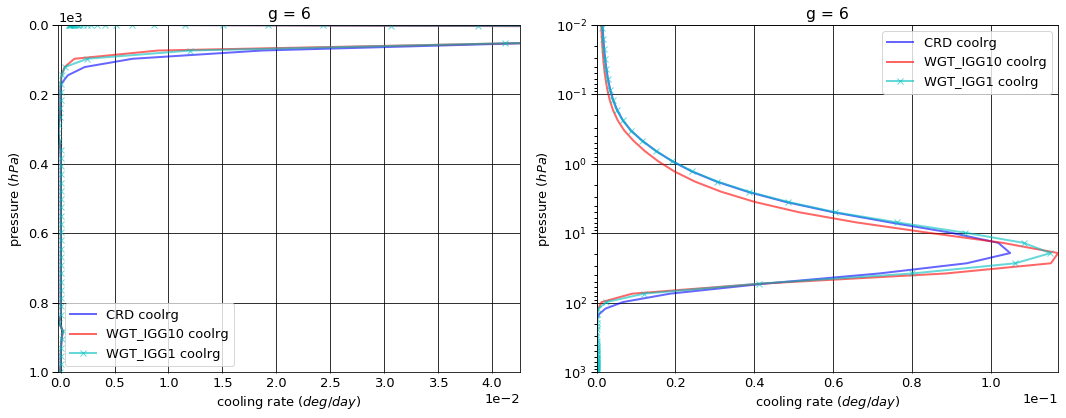

# Figure: cooling rate g-group 7

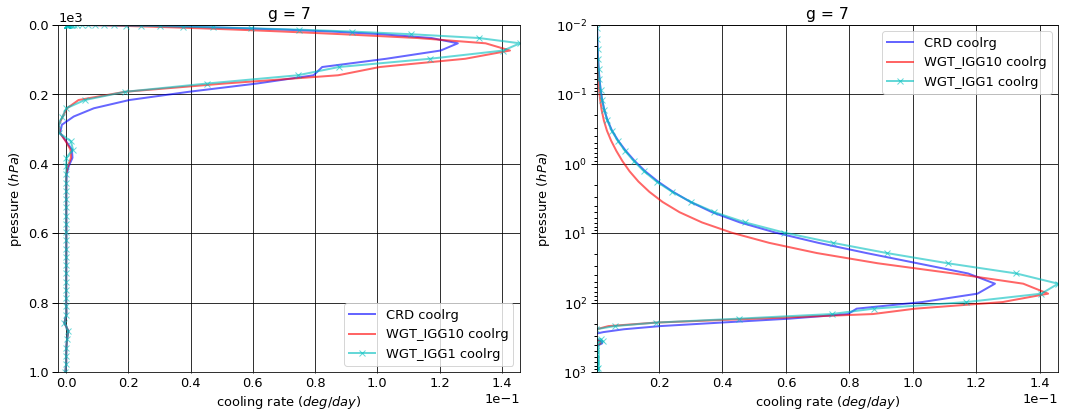

# Figure: cooling rate g-group 8

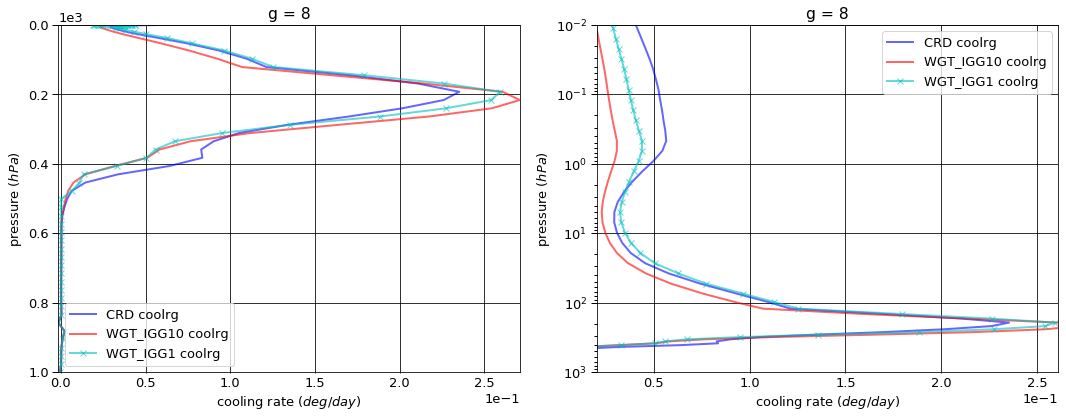

# Figure: cooling rate g-group 9

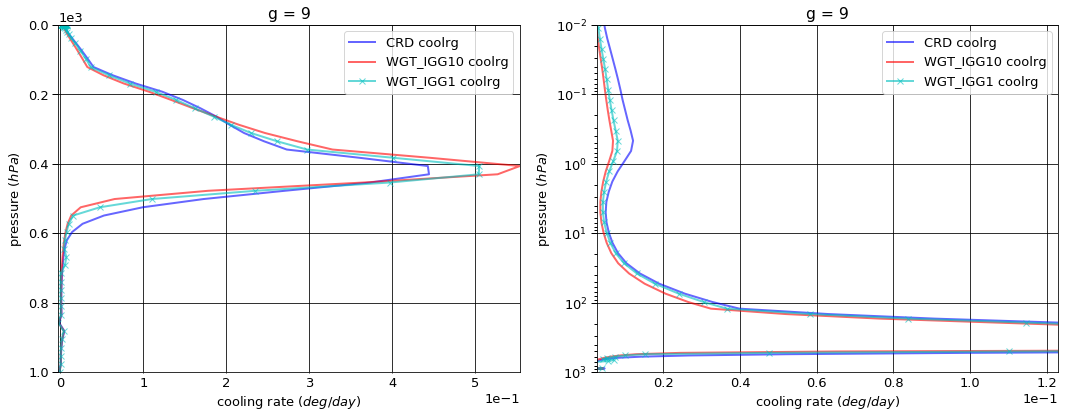

# Figure: cooling rate g-group 10

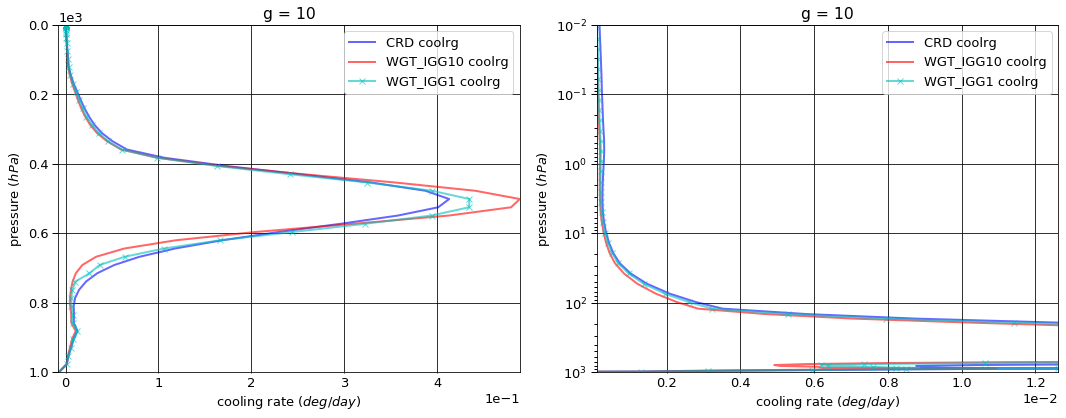

# Figure: cooling rate g-group total

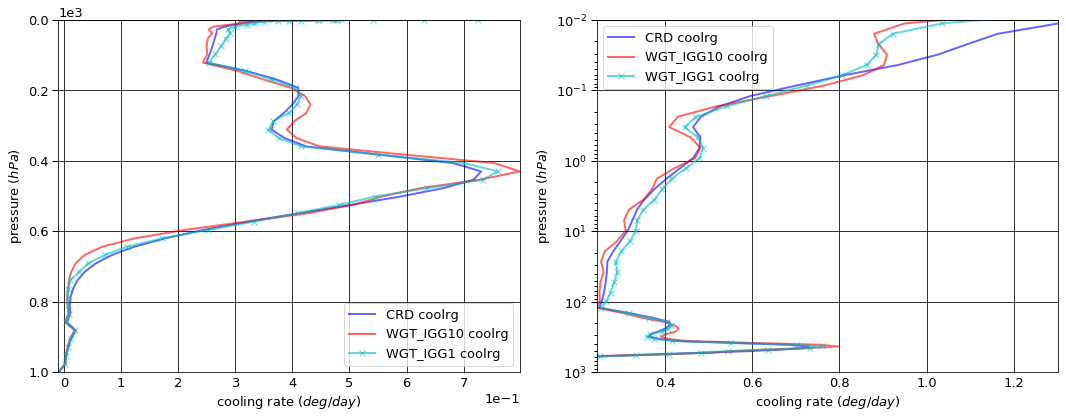

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg         fnetg
g  pressure level                                    
1  0.0      1      -0.003015   0.000000 -3.014940e-03
   1013.0   76     -0.003937   0.003938  8.191969e-07
2  0.0      1      -0.012955   0.000000 -1.295512e-02
   1013.0   76     -0.014182   0.014186  3.562163e-06
3  0.0      1      -0.034998   0.000000 -3.499782e-02
   1013.0   76     -0.036720   0.036728  8.120802e-06
4  0.0      1      -0.073543   0.000000 -7.354314e-02
   1013.0   76     -0.087243   0.087262  1.908703e-05
5  0.0      1      -0.279916   0.000000 -2.799162e-01
   1013.0   76     -0.368968   0.369049  8.130835e-05
6  0.0      1      -0.596623   0.000000 -5.966225e-01
   1013.0   76     -0.818951   0.819131  1.801548e-04
7  0.0      1      -2.174146   0.000000 -2.174146e+00
   1013.0   76     -2.964918   2.965575  6.569316e-04
8  0.0      1      -6.484766   0.000000 -6.484766e+00
   1013.0   76     -8.695107   8.697048  1.940637e-03
9  0.0      1     -11.667547   0.000000 -1.166755e+01
   1013.0   76    -14.787630  14.793546  5.915735e-03
10 0.0      1     -10.616407   0.000000 -1.061641e+01
   1013.0   76    -12.483813  12.516567  3.275475e-02


WGT_IGG10


flug       fldg         fnetg
g  pressure level                                    
1  0.0      1      -0.003016   0.000000 -3.016232e-03
   1013.0   76     -0.003937   0.003938  8.191969e-07
2  0.0      1      -0.013056   0.000000 -1.305640e-02
   1013.0   76     -0.014182   0.014186  3.562163e-06
3  0.0      1      -0.035455   0.000000 -3.545544e-02
   1013.0   76     -0.036720   0.036728  8.120802e-06
4  0.0      1      -0.074874   0.000000 -7.487392e-02
   1013.0   76     -0.087243   0.087262  1.908703e-05
5  0.0      1      -0.280586   0.000000 -2.805865e-01
   1013.0   76     -0.368968   0.369049  8.130835e-05
6  0.0      1      -0.594469   0.000000 -5.944693e-01
   1013.0   76     -0.818951   0.819131  1.801548e-04
7  0.0      1      -2.173034   0.000000 -2.173034e+00
   1013.0   76     -2.964918   2.965575  6.569316e-04
8  0.0      1      -6.452772   0.000000 -6.452772e+00
   1013.0   76     -8.695107   8.697044  1.936925e-03
9  0.0      1     -11.561023   0.000000 -1.156102e+01
   1013.0   76    -14.787630  14.792052  4.422197e-03
10 0.0      1     -10.558053   0.000000 -1.055805e+01
   1013.0   76    -12.483813  12.510236  2.642312e-02


WGT_IGG1


flug       fldg         fnetg
g  pressure level                                    
1  0.0      1      -0.003018   0.000000 -3.018100e-03
   1013.0   76     -0.003937   0.003938  8.191969e-07
2  0.0      1      -0.013094   0.000000 -1.309360e-02
   1013.0   76     -0.014182   0.014186  3.562163e-06
3  0.0      1      -0.035223   0.000000 -3.522332e-02
   1013.0   76     -0.036720   0.036728  8.120802e-06
4  0.0      1      -0.074516   0.000000 -7.451560e-02
   1013.0   76     -0.087243   0.087262  1.908703e-05
5  0.0      1      -0.280731   0.000000 -2.807311e-01
   1013.0   76     -0.368968   0.369049  8.130835e-05
6  0.0      1      -0.595676   0.000000 -5.956760e-01
   1013.0   76     -0.818951   0.819131  1.801548e-04
7  0.0      1      -2.170431   0.000000 -2.170431e+00
   1013.0   76     -2.964918   2.965575  6.569316e-04
8  0.0      1      -6.449141   0.000000 -6.449141e+00
   1013.0   76     -8.695107   8.697044  1.936925e-03
9  0.0      1     -11.597287   0.000000 -1.159729e+01
   1013.0   76    -14.787630  14.791020  3.390166e-03
10 0.0      1     -10.609912   0.000000 -1.060991e+01
   1013.0   76    -12.483813  12.516063  3.225079e-02


WGT_IGG10 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1     -1.292000e-06  0.000000e+00 -1.292000e-06
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2  0.0      1     -1.012810e-04  0.000000e+00 -1.012810e-04
   1013.0   76    -1.734723e-18  1.734723e-18  0.000000e+00
3  0.0      1     -4.576200e-04  0.000000e+00 -4.576200e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
4  0.0      1     -1.330783e-03  0.000000e+00 -1.330783e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
5  0.0      1     -6.703000e-04  0.000000e+00 -6.703000e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
6  0.0      1      2.153240e-03  0.000000e+00  2.153240e-03
   1013.0   76     0.000000e+00  0.000000e+00  2.710505e-20
7  0.0      1      1.111500e-03  0.000000e+00  1.111500e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
8  0.0      1      3.199350e-02  0.000000e+00  3.199350e-02
   1013.0   76     0.000000e+00 -3.700000e-06 -3.711200e-06
9  0.0      1      1.065240e-01  0.000000e+00  1.065240e-01
   1013.0   76     0.000000e+00 -1.494000e-03 -1.493537e-03
10 0.0      1      5.835400e-02  0.000000e+00  5.835400e-02
   1013.0   76     0.000000e+00 -6.331000e-03 -6.331623e-03


WGT_IGG1 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1     -3.159600e-06  0.000000e+00 -3.159600e-06
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2  0.0      1     -1.384820e-04  0.000000e+00 -1.384820e-04
   1013.0   76    -1.734723e-18  1.734723e-18  0.000000e+00
3  0.0      1     -2.254980e-04  0.000000e+00 -2.254980e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
4  0.0      1     -9.724600e-04  0.000000e+00 -9.724600e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
5  0.0      1     -8.149600e-04  0.000000e+00 -8.149600e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
6  0.0      1      9.465800e-04  0.000000e+00  9.465800e-04
   1013.0   76     0.000000e+00  0.000000e+00  2.710505e-20
7  0.0      1      3.714500e-03  0.000000e+00  3.714500e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
8  0.0      1      3.562460e-02  0.000000e+00  3.562460e-02
   1013.0   76     0.000000e+00 -3.700000e-06 -3.711200e-06
9  0.0      1      7.026000e-02  0.000000e+00  7.026000e-02
   1013.0   76     0.000000e+00 -2.526000e-03 -2.525568e-03
10 0.0      1      6.495000e-03  0.000000e+00  6.495000e-03
   1013.0   76     0.000000e+00 -5.040000e-04 -5.039620e-04

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.041370e+01
   1001.112500 75    -2.378761e-07
2  0.000312    1      4.242014e-01
   1001.112500 75    -1.034804e-06
3  0.000312    1      7.461927e-02
   1001.112500 75    -2.358425e-06
4  0.000312    1      3.180886e-05
   1001.112500 75    -5.543148e-06
5  0.000312    1      7.151864e-05
   1001.112500 75    -2.361341e-05
6  0.000312    1      7.870637e-04
   1001.112500 75    -5.231967e-05
7  0.000312    1      2.072311e-04
   1001.112500 75    -1.907873e-04
8  0.000312    1      2.558090e-02
   1001.112500 75    -5.635407e-04
9  0.000312    1      1.718796e-03
   1001.112500 75    -1.692441e-03
10 0.000312    1      1.047174e-04
   1001.112500 75    -7.326927e-03


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      8.256215e+00
   1001.112500 75    -2.378761e-07
2  0.000312    1      2.781639e-01
   1001.112500 75    -1.034804e-06
3  0.000312    1      3.585229e-02
   1001.112500 75    -2.358425e-06
4  0.000312    1      3.011183e-05
   1001.112500 75    -5.543148e-06
5  0.000312    1      6.708516e-05
   1001.112500 75    -2.361341e-05
6  0.000312    1      6.226258e-04
   1001.112500 75    -5.231967e-05
7  0.000312    1      1.381614e-04
   1001.112500 75    -1.907873e-04
8  0.000312    1      1.315281e-02
   1001.112500 75    -5.625275e-04
9  0.000312    1      9.431621e-04
   1001.112500 75    -1.275205e-03
10 0.000312    1      5.544951e-05
   1001.112500 75    -6.865826e-03


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      9.124483e+00
   1001.112500 75    -2.378761e-07
2  0.000312    1      3.191266e-01
   1001.112500 75    -1.034804e-06
3  0.000312    1      3.988219e-02
   1001.112500 75    -2.358425e-06
4  0.000312    1      3.211654e-05
   1001.112500 75    -5.543148e-06
5  0.000312    1      7.627144e-05
   1001.112500 75    -2.361341e-05
6  0.000312    1      7.655213e-04
   1001.112500 75    -5.231967e-05
7  0.000312    1      1.969241e-04
   1001.112500 75    -1.907873e-04
8  0.000312    1      1.878841e-02
   1001.112500 75    -5.625275e-04
9  0.000312    1      1.123721e-03
   1001.112500 75    -9.846357e-04
10 0.000312    1      6.378005e-05
   1001.112500 75    -7.745681e-03


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -2.157486e+00
   1001.112500 75     0.000000e+00
2  0.000312    1     -1.460375e-01
   1001.112500 75     0.000000e+00
3  0.000312    1     -3.876698e-02
   1001.112500 75     0.000000e+00
4  0.000312    1     -1.697034e-06
   1001.112500 75     0.000000e+00
5  0.000312    1     -4.433487e-06
   1001.112500 75     0.000000e+00
6  0.000312    1     -1.644378e-04
   1001.112500 75     0.000000e+00
7  0.000312    1     -6.906969e-05
   1001.112500 75    -2.710505e-20
8  0.000312    1     -1.242809e-02
   1001.112500 75     1.013180e-06
9  0.000312    1     -7.756342e-04
   1001.112500 75     4.172367e-04
10 0.000312    1     -4.926791e-05
   1001.112500 75     4.611012e-04


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.289218e+00
   1001.112500 75     0.000000e+00
2  0.000312    1     -1.050748e-01
   1001.112500 75     0.000000e+00
3  0.000312    1     -3.473709e-02
   1001.112500 75     0.000000e+00
4  0.000312    1      3.076790e-07
   1001.112500 75     0.000000e+00
5  0.000312    1      4.752801e-06
   1001.112500 75     0.000000e+00
6  0.000312    1     -2.154233e-05
   1001.112500 75     0.000000e+00
7  0.000312    1     -1.030699e-05
   1001.112500 75    -2.710505e-20
8  0.000312    1     -6.792489e-03
   1001.112500 75     1.013180e-06
9  0.000312    1     -5.950750e-04
   1001.112500 75     7.078057e-04
10 0.000312    1     -4.093737e-05
   1001.112500 75    -4.187542e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.943915,0.000000,-31.943915
1013.0,76,-40.261468,40.303029,0.041561



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.746340,0.0000,-31.746340
1013.0,76,-40.261468,40.2952,0.033732



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.829029,0.000000,-31.829029
1013.0,76,-40.261468,40.299995,0.038528



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.197575,0.000000,0.197575
1013.0,76,0.000000,-0.007829,-0.007829



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.114886,0.000000,0.114886
1013.0,76,0.000000,-0.003034,-0.003033


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,10.941024
1001.112500,75,-0.009859



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,8.585241
1001.112500,75,-0.008979



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,9.504538
1001.112500,75,-0.009569



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.355783
1001.112500,75,0.000879



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-1.436485
1001.112500,75,0.000290


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000125,0.000098
2,0.000313,0.000351
3,0.001000,0.000915
4,0.002687,0.002176
5,0.011000,0.009197
6,0.023375,0.020414
7,0.088188,0.073902
8,0.250437,0.216633
9,0.391250,0.367904


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.372307e-16
2,2.601420e-17
3,2.852660e-18
4,5.740151e-18
5,6.832022e-19
6,7.155529e-19
7,8.793590e-20
8,1.080664e-20
9,1.328052e-21


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.372307e-16,NaN,0.000125,0.000098,0.000125,0.000098,1.0
2,2.601420e-17,0.109658,0.000313,0.000351,0.000438,0.000450,1.0
3,2.852660e-18,0.109658,0.001000,0.000915,0.001437,0.001364,1.0
4,5.740151e-18,2.012210,0.002687,0.002176,0.004125,0.003541,30.0
5,6.832022e-19,0.119022,0.011000,0.009197,0.015125,0.012738,30.0
6,7.155529e-19,1.047351,0.023375,0.020414,0.038500,0.033152,300.0
7,8.793590e-20,0.122892,0.088188,0.073902,0.126688,0.107054,300.0
8,1.080664e-20,0.122892,0.250437,0.216633,0.377125,0.323686,300.0
9,1.328052e-21,0.122892,0.391250,0.367904,0.768375,0.691590,300.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [27]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g  pressure                                                        
1     1  0.000312     2.428372e-15  1.767634e-15   1.373798  1.674145e-01
      2  0.000312     2.966280e-17  1.964387e-17   1.510028  1.928861e-03
      3  0.000312     2.146099e-18  5.953685e-19   3.604657  9.032086e-05
      4  0.000312     2.986756e-22  2.986702e-22   1.000018  2.543524e-08
      5  0.000312     1.433851e-22  1.422268e-22   1.008144  1.214179e-08
      6  0.000312     6.698304e-22  5.713573e-22   1.172350  5.117327e-08
      7  0.000312     4.627473e-23  3.745336e-23   1.235529  3.640313e-09
      8  0.000312     2.312894e-21  6.363213e-23  36.347890  1.203488e-07
      9  0.000312     8.606793e-23  4.687692e-24  18.360406  4.557470e-09
      10 0.000312     7.417223e-24  3.240505e-25  22.889093  3.900341e-10
2     1  0.000750     2.414189e-15  1.768168e-15   1.365362  6.729919e-02
      2  0.000750     3.060981e-17  2.009269e-17   1.523430  7.974418e-04
      3  0.000750     2.178368e-18  6.019102e-19   3.619092  3.686918e-05
      4  0.000750     6.817723e-22  6.817449e-22   1.000040  2.338534e-08
      5  0.000750     1.860769e-22  1.847429e-22   1.007221  6.350737e-09
      6  0.000750     6.820101e-22  5.812742e-22   1.173302  2.097536e-08
      7  0.000750     4.761846e-23  3.858196e-23   1.234216  1.509411e-09
      8  0.000750     2.320618e-21  6.407251e-23  36.218620  4.863990e-08
      9  0.000750     8.896820e-23  4.772775e-24  18.640769  1.896546e-09
      10 0.000750     7.438238e-24  3.294742e-25  22.576088  1.576075e-10
3     1  0.001052     2.386103e-15  1.768878e-15   1.348936  9.399803e-02
      2  0.001052     3.254540e-17  2.092478e-17   1.555352  1.174273e-03
      3  0.001052     2.239191e-18  6.101645e-19   3.669816  5.286052e-05
      4  0.001052     9.439148e-22  9.438631e-22   1.000055  4.540464e-08
      5  0.001052     2.265748e-22  2.248459e-22   1.007689  1.084101e-08
      6  0.001052     7.018863e-22  5.965217e-22   1.176632  3.021582e-08
      7  0.001052     4.940643e-23  3.993100e-23   1.237295  2.194339e-09
      8  0.001052     2.336536e-21  6.480235e-23  36.056344  6.868539e-08
      9  0.001052     9.518365e-23  4.933367e-24  19.293854  2.842173e-09
      10 0.001052     7.480151e-24  3.395999e-25  22.026360  2.224310e-10
4     1  0.001476     2.357764e-15  1.768830e-15   1.332951  1.312931e-01
      2  0.001476     3.459347e-17  2.177641e-17   1.588576  1.729073e-03
      3  0.001476     2.302578e-18  6.195381e-19   3.716604  7.588370e-05
      4  0.001476     1.309826e-21  1.309727e-21   1.000075  8.838916e-08
      5  0.001476     2.793358e-22  2.770861e-22   1.008119  1.874474e-08
      6  0.001476     7.231305e-22  6.130194e-22   1.179621  4.359897e-08
      7  0.001476     5.140843e-23  4.148088e-23   1.239328  3.201321e-09
      8  0.001476     2.353182e-21  6.558396e-23  35.880452  9.705330e-08
      9  0.001476     1.020531e-22  5.103897e-24  19.995130  4.270016e-09
      10 0.001476     7.522380e-24  3.506018e-25  21.455624  3.140536e-10
5     1  0.002070     2.329485e-15  1.768002e-15   1.317581  1.832921e-01
      2  0.002070     3.673343e-17  2.264210e-17   1.622350  2.543300e-03
      3  0.002070     2.368170e-18  6.304016e-19   3.756604  1.090158e-04
      4  0.002070     1.820864e-21  1.820677e-21   1.000103  1.723393e-07
      5  0.002070     3.485825e-22  3.456495e-22   1.008485  3.280033e-08
      6  0.002070     7.459452e-22  6.310364e-22   1.182095  6.299296e-08
      7  0.002070     5.368554e-23  4.329856e-23   1.239892  4.688274e-09
      8  0.002070     2.370393e-21  6.642496e-23  35.685273  1.371350e-07
      9  0.002070     1.095541e-22  5.283399e-24  20.735542  6.421867e-09
      10 0.002070     7.564585e-24  3.625258e-25  20.866334  4.433359e-10
6     1  0.002904     2.301220e-15  1.766384e-15   1.302786  2.558345e-01
      2  0.002904     3.896912e-17  2.352937e-17   1.656191  3.739101e-03
      3  0.002904     2.436503e

# Histogram of wavenumbers in g-group 1

In [28]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [29]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
